## Manuscript Plots

In [55]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.ticker as mtick
from matplotlib.pyplot import figure
from matplotlib import collections  as mc

from tqdm import tnrange, tqdm_notebook

In [5]:
import os
import sys
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [6]:
from cvtk.plots import correction_diagnostic_plot
from cvtk.bootstrap import bootstrap_ci

In [7]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (6.0, 2.50)
mpl.rcParams['figure.dpi'] = 200

In [258]:
# image sizes
ONECOL = 3.42
THREEHALVESCOL = 4.5
TWOCOL = 7
plt.style.use('./buffalo.mplstyle')

## Barghi et al (2019) Combined Plots

In [259]:
barghi_gw_temp_covs_cis = np.load("../../data/barghi_et_al_2019/gw_temp_covs_cis.npy")
barghi_g_cis_averep = np.load("../../data/barghi_et_al_2019/g_cis_averep.npy")
barghi_g = np.load("../../data/barghi_et_al_2019/g.npy")

In [260]:
def cov_plot(cov_cis, ax=None, alpha=1, error_alpha=1, ngens=1, linewidth=1, ylim=None, xlim=None, hline=True, 
             cmap=cm.Dark2, y_multiplier=None, xticks=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    _, T, T = cov_cis.shape
    y_multiplier = y_multiplier if y_multiplier is not None else 1
    mid_T = (T-4)/2
    for refgen in range(T):
        x = 2*ngens + np.arange(refgen, T) * ngens - mid_T + refgen*0.7  # TODO a bit of a hack
        mean = y_multiplier*cov_cis[1][refgen, (refgen+1):]
        lower, upper = y_multiplier*cov_cis[0][refgen, (refgen+1):]-mean, mean-y_multiplier*cov_cis[2][refgen, (refgen+1):]
        
        #ax.plot(np.broadcast_to(ngens*np.arange(refgen, T), (2, T-refgen)), temp_covs_bs[(0, 2), refgen, refgen:])
        ax.plot(x[:-1], mean, '-o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
                label=refgen, zorder=refgen, markersize=2.5) #markersize=3.5)#, markeredgecolor='w')
        #ax.plot(x[:-1], mean, 'o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
        #        label=refgen, zorder=refgen) #markersize=4.3)# markeredgecolor='w')
        ax.errorbar(x[:-1], mean, yerr=np.column_stack([lower.ravel(), upper.ravel()]).T, 
                    capsize=0, elinewidth=linewidth, c=cmap(refgen), 
                    linewidth=0,
                    zorder=100+refgen, alpha=error_alpha, label=None, solid_capstyle='round')

    if ylim is not None:
        plt.ylim(ylim)
    
    if xlim is not None:
        plt.xlim(xlim)
    #plt.xticks(np.arange(0, T*ngens, 10))
    if xticks is not None:
        plt.xticks(xticks)
    if hline:
        ax.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1e6, linestyle='--')
    
    if ylab is None:
        ylab = "covariance"
        if y_multiplier is not None:
            ylab += f"  $(\\times 10^{{{int(np.log10(1/y_multiplier))}}})$"
        
#     ylab = "covariance "
#     if y_multiplier is not None:
#         ylab += "\n $\\mathrm{cov}(\\Delta p_s, \\Delta p_t)$"
#         ylab += f"  $ \\times 10^{{{int(np.log10(1/y_multiplier))}}}$"
#     add_latex = False
#     if add_latex:
#         ylab += "\n $\\mathrm{cov}(\\Delta p_s, \\Delta p_t)$"       
        
    ax.set_ylabel(ylab)
    #plt.legend(loc=(0.02, 0.75))

In [261]:
def G_plot(g, g_averep_cis=None, alpha=1, point_alpha=1, linewidth=1, ax=None, 
           ylim=None, xlim=None, as_percent=True, hline=True, cmap=None, ci_col='0.2',
           rep_markersize=0):
    if ax is None:
        fig, ax = plt.subplots()
    T, R = g.shape
    y_multiplier = 100. if as_percent else 1.
    x = np.arange(1, T+1) * 10
    cmap = cm.viridis if cmap is None else cmap
    cols = cmap(np.linspace(0, 1, T-1))
    for rep in range(R):
        for t in range(T-1):
            xa = x[t:(t+2)]
            mean = g[t:(t+2), rep]
            #import pdb; pdb.set_trace()
            ax.plot(xa, y_multiplier*mean, '-o', linewidth=linewidth, c=cols[t],
                    alpha=alpha, zorder=-t, markersize=rep_markersize, solid_capstyle='round')  #markeredgecolor='w')
            ax.plot(xa, y_multiplier*mean, 'o', linewidth=linewidth, c=cols[t],
                    alpha=point_alpha, zorder=-t, markersize=rep_markersize, solid_capstyle='round')#,  markeredgecolor='w')
            
    if g_averep_cis is not None:
        mean = g_averep_cis[1, :]
        lower, upper = g_averep_cis[0, :]-mean, mean-g_averep_cis[2, :]
        ax.plot(x, y_multiplier*mean, '-o', linewidth=linewidth, c=ci_col, markerfacecolor='w',
                zorder=1e4, markersize=2)#, markeredgecolor='w', markeredgewidth=3)
        ax.errorbar(x, y_multiplier*mean, yerr=y_multiplier*np.column_stack([lower.ravel(), upper.ravel()]).T, 
                     capsize=0, elinewidth=linewidth*1.3, linewidth=0,
                     zorder=1e5, alpha=1, c=ci_col, label=None, solid_capstyle='round')
        ax.plot(x, y_multiplier*mean, 'o', linewidth=linewidth, c='k',
               zorder=np.Inf, markersize=2.1)
        

    if ylim is not None:
        plt.ylim(ylim)
    
    if xlim is not None:
        plt.xlim(xlim)
    if hline:
        ax.axhline(y=0, c='0.6', linewidth=0.5, zorder=-100, linestyle='--')

    ax.set_xlabel("generation ($t$)")
    ax.set_ylabel("$G(t)$")

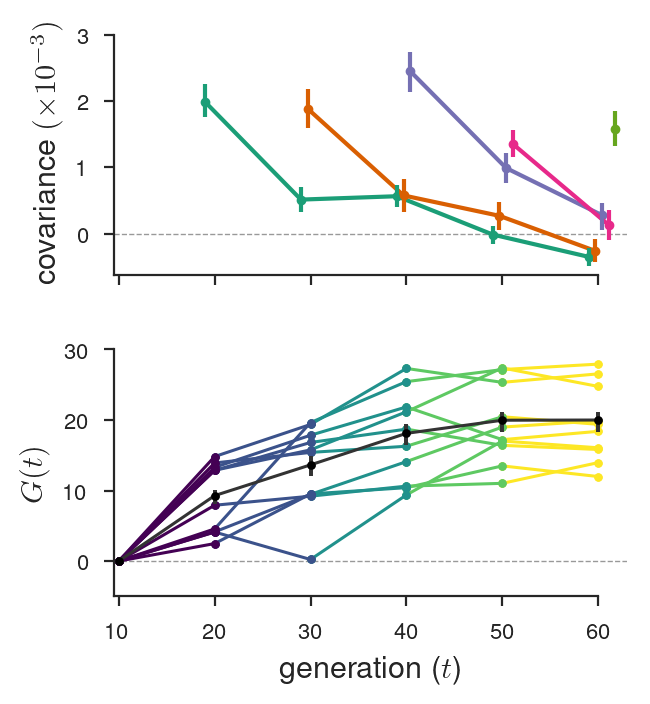

In [262]:
#plt.rc('text', usetex=False)
plt.rc('text', usetex=True)
plt.style.use('./buffalo.mplstyle')

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(ONECOL*1.5, ONECOL*1.1))

cov_plot(barghi_gw_temp_covs_cis, ax=ax[0], ngens=10, xlim=(9.5, 63), y_multiplier=1000, 
         linewidth=1.5, xticks=np.arange(0, 63, 10))
G_plot(barghi_g, barghi_g_cis_averep, ax=ax[1], xlim=(9.5, 63), ylim=(-5, 30),
       linewidth=1.1, alpha=1, rep_markersize=2)


# customize plots
#ax[0].spines['bottom'].set_bounds(10, 60)
#ax[0].spines['bottom'].set_bounds(9.7, 60)
#ax[0].spines['left'].set_bounds(-0.6, 2)
#ax[0].spines['left'].set_bounds(0, 2)  # end top y axis at 0
# this drops top y axis below 0
#ax[1].spines['left'].set_position(('axes', -0.01))
# this combines the top y axis with the x axis
#ax[0].spines['left'].set_position(('axes', 0.01))
#ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
#ax[0].yaxis.set_major_formatter(mtick.LogFormatterMathtext())

#ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"${int(x)}\\%$"))

# uncomment if you don't want latex tick labels
ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{int(x)}%"))
# ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x}"))
ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x}"))
ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{int(x)}"))

ax[0].spines['bottom'].set_bounds(9.5, 60)
ax[1].spines['bottom'].set_bounds(9.5, 60)
ax[0].spines['left'].set_bounds(-0.63, 3)
ax[0].set_ylim(-0.63, 3.1)
ax[1].spines['left'].set_bounds(-5, 30)
#ax[1].spines['left'].set_bounds(-3, 20)
#ax[1].spines['left'].set_bounds(0, 20)

plt.subplots_adjust(wspace=0.3, hspace=0.3, left=.4)
fig.savefig("figure-1-G-covs.pdf", bbox_inches='tight')

In [263]:
barghi_g_cis_averep

array([[0.        , 0.08542407, 0.12448255, 0.16845072, 0.18751367,
        0.18883686],
       [0.        , 0.09278597, 0.13635574, 0.18102241, 0.19962738,
        0.19991532],
       [0.        , 0.10479589, 0.15235281, 0.19787816, 0.2167262 ,
        0.21642803]])

## Castro et al (2019)

In [264]:
castro_covs_cis = np.load("../../data/castro_et_al_2019/castro_et_al_2019_covs_bootstrap.npy")

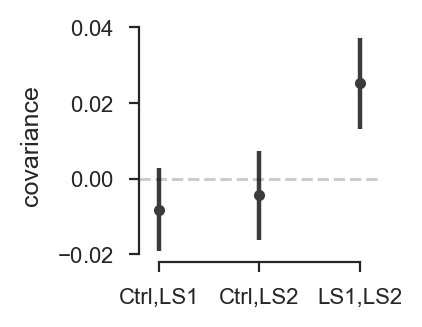

In [265]:
plt.style.use('buffalo.mplstyle')
plt.rc('text', usetex=False)

mean = castro_covs_cis[1]
mpl.rcParams['figure.figsize'] = (ONECOL/2.2, ONECOL/2.2)
#plt.figure(figsize=(5, 5))
lower, upper = castro_covs_cis[0]-mean, mean-castro_covs_cis[2]
#comps = [('cov($\Delta p_\mathrm{Ctrl}, \Delta p_\mathrm{LS1}$)', 0, 1), ('cov($\Delta p_\mathrm{Ctrl}, \Delta p_\mathrm{LS2}$)', 0, 2), ('cov($\Delta p_\mathrm{LS1}, \Delta p_\mathrm{LS2}$)', 1, 2)]
comps = [('Ctrl,LS1', 0, 1), 
         ('Ctrl,LS2', 0, 2), 
         ('LS1,LS2', 1, 2)]
means = [mean[r, c] for _, r, c in comps]
bounds = np.stack([(lower[r, c], upper[r, c]) for _, r, c in comps]).T
labels = [l for l, _, _ in comps]
  
ax = plt.subplot()    
ax.errorbar(labels, means, yerr=bounds, capsize=0, fmt='o', linewidth=2, elinewidth=1.6, markersize=3, c='0.23')
ax.axhline(y=0, c='k', alpha=0.2, linestyle='--')

ax.spines['left'].set_bounds(-0.02, 0.04)
ax.spines['bottom'].set_bounds(0, 2)
#ax.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('covariance', fontsize=9) #, fontsize=13)
ax.set_xlim(-0.2, 2.2)
#plt.xlabel('comparison')
#ax.set_xticklabels(labels, rotation = 45, ha="right")
plt.savefig('castro_rep_cis.pdf', bbox_inches="tight")


## Kelly and Hughes (2019)

In [266]:
kh_covs_cis = np.load("../../data/kelly_hughes_2019/kelly_hughes_2019_covs_bootstrap.npy")

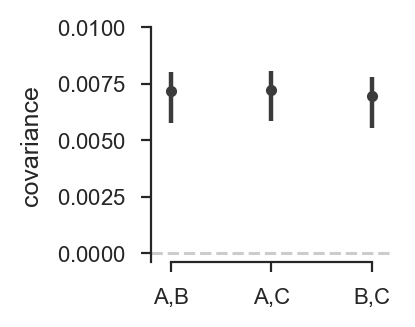

In [267]:
plt.style.use('buffalo.mplstyle')
plt.rc('text', usetex=False)

mean = kh_covs_cis[1]
mpl.rcParams['figure.figsize'] = (ONECOL/2.2, ONECOL/2.2)
#plt.figure(figsize=(5, 5))
lower, upper = kh_covs_cis[0]-mean, mean-kh_covs_cis[2]
comps = [('A,B', 0, 1), 
         ('A,C', 0, 2), 
         ('B,C', 1, 2)]
means = [mean[r, c] for _, r, c in comps]
bounds = np.stack([(lower[r, c], upper[r, c]) for _, r, c in comps]).T
labels = [l for l, _, _ in comps]
  
ax = plt.subplot()
ax.errorbar(labels, means, yerr=bounds, capsize=0, fmt='o', linewidth=2, elinewidth=1.6, markersize=3, c='0.23')
ax.axhline(y=0, c='k', alpha=0.2, linestyle='--')


#ax.spines['left'].set_bounds(-0.02, 0.04)
ax.spines['bottom'].set_bounds(-0, 2)
ax.spines['left'].set_bounds(-0.0004, 0.01)
#ax.tick_params(axis='both', which='major', labelsize=10)
#plt.ylabel('covariance', fontsize=13)
ax.set_ylim(-0.0004, 0.01)
ax.set_xlim(-0.2, 2.2)
plt.ylabel('covariance', fontsize=9)
#plt.xlabel('comparison')
#ax.set_xticklabels(labels, rotation = 45, ha="right")
#plt.savefig('castro_rep_cis.pdf', bbox_inches="tight")
plt.savefig('kh_rep_cis.pdf', bbox_inches="tight")



Confidence intervals in paper:

In [506]:
np.round(kh_covs_cis[:, (0, 0, 1), (1, 2, 2)], 5)

array([[0.00634, 0.00635, 0.00607],
       [0.00718, 0.0072 , 0.00693],
       [0.00859, 0.00857, 0.00833]])

### Barghi Convergence Correlation Plot

In [268]:
barghi_conv_corr_cis = np.load("../../data/barghi_et_al_2019/barghi_et_al_2019_conv_corr_cis.npy")[:, 0, ...]

In [269]:
def convcorr_plot(cov_cis, ax=None, alpha=1, error_alpha=1, ngens=1, linewidth=1, ylim=None, xlim=None, hline=True, 
             cmap=cm.Dark2, y_multiplier=None, xticks=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    _, T, T = cov_cis.shape
    y_multiplier = y_multiplier if y_multiplier is not None else 1
    mid_T = (T-4)/2
    for refgen in range(T):
        x = ngens + np.arange(refgen, T) * ngens - mid_T + refgen*0.7  # TODO a bit of a hack
        mean = y_multiplier*cov_cis[1][refgen, refgen:]
        lower, upper = y_multiplier*cov_cis[0][refgen, refgen:]-mean, mean-y_multiplier*cov_cis[2][refgen, refgen:]
        
        #ax.plot(np.broadcast_to(ngens*np.arange(refgen, T), (2, T-refgen)), temp_covs_bs[(0, 2), refgen, refgen:])
        ax.plot(x, mean, '-o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
                label=refgen, zorder=refgen, markersize=2.) #, markersize=3., markeredgecolor='w')
        #ax.plot(x, mean, 'o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
        #        label=refgen, zorder=refgen) #, markersize=3.5, markeredgecolor='w')
        ax.errorbar(x, mean, yerr=np.column_stack([lower.ravel(), upper.ravel()]).T, 
                    capsize=0, elinewidth=linewidth, c=cmap(refgen), 
                    linewidth=0,
                    zorder=refgen, alpha=error_alpha, label=None, solid_capstyle='round')

    if ylim is not None:
        plt.ylim(ylim)
    
    if xlim is not None:
        plt.xlim(xlim)
    #plt.xticks(np.arange(0, T*ngens, 10))
    if xticks is not None:
        plt.xticks(xticks)
    if hline:
        ax.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1e6, linestyle='--')
    
    if ylab is None:
        ylab = "covariance"
        if y_multiplier is not None:
            ylab += f"  $(\\times 10^{{{int(np.log10(1/y_multiplier))}}})$"
        
#     ylab = "covariance "
#     if y_multiplier is not None:
#         ylab += "\n $\\mathrm{cov}(\\Delta p_s, \\Delta p_t)$"
#         ylab += f"  $ \\times 10^{{{int(np.log10(1/y_multiplier))}}}$"
#     add_latex = False
#     if add_latex:
#         ylab += "\n $\\mathrm{cov}(\\Delta p_s, \\Delta p_t)$"       
        
    ax.set_ylabel(ylab)
    #plt.legend(loc=(0.02, 0.75))

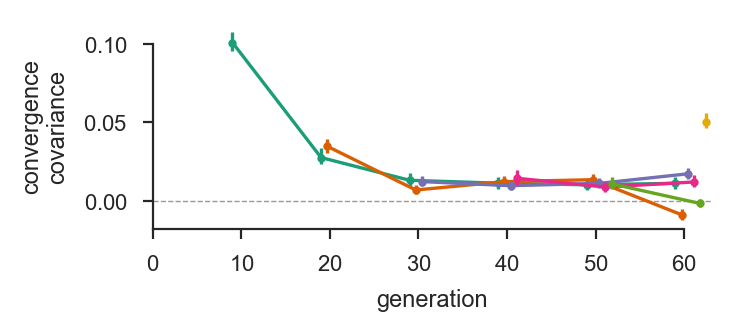

In [270]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(THREEHALVESCOL*0.8, ONECOL/2.5))

convcorr_plot(barghi_conv_corr_cis, ax=ax, ngens=10, xlim=(9.5, 63), y_multiplier=None, linewidth=1.2,
              xticks=np.arange(0, 63, 10), ylab='convergence\ncorrelation')

ax.set_xlabel("generation", fontsize=8.5)
ax.set_ylabel("convergence\ncovariance", fontsize=8.5)


ax.spines['left'].set_bounds(-0.018, 0.1)
ax.spines['bottom'].set_bounds(0, 60)
fig.savefig("figure-2-corr.pdf", bbox_inches='tight')

In the paper, we mention the bootstrap CIs for the first timepoint; these are:

In [488]:
barghi_conv_corr_cis[:, 0, 0]

array([0.09428963, 0.10111382, 0.10666285])

Twenty generations later:

In [492]:
barghi_conv_corr_cis[:, 2, 2]

array([0.00871028, 0.0121614 , 0.01494563])

## Barghi et al (2019) Empirical Null

In [271]:
barghi_emp_null_tile = np.load('../../data/barghi_et_al_2019/empnull_tile_1e5.npy')
barghi_emp_null_seqid = np.load('../../data/barghi_et_al_2019/empnull_seqid_1e5.npy')
barghi_tile_covs = np.load('../../data/barghi_et_al_2019/tile_temporal_covs_1e5.npy')

### Cross-validating Binsize

In [272]:
nbins = np.arange(10, 200, 10)

def histogram_risk(data, bins):
    assert(data.ndim == 1)
    densities, bins = np.histogram(data, bins, density=True)
    phat = densities * np.diff(bins)
    np.testing.assert_almost_equal(phat.sum(), 1)
    n = data.shape[0]
    h = np.diff(bins).mean()
    return 2 / (h*n-h) - (n+1)/(h*n-h) * (phat**2).sum()

def estimated_cv_risk(data, ns, xmin, xmax, progress=True):
    risks = []
    ns_range = tqdm_notebook(ns) if progress else ns
    for n in ns_range:
        bins = np.linspace(xmin, xmax, n)
        risks.append(histogram_risk(data, bins))
    return ns, np.array(risks)

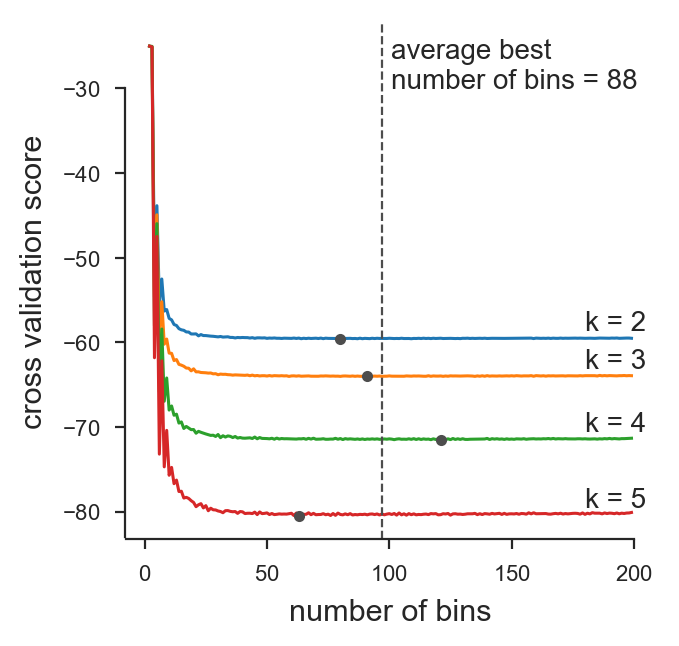

In [342]:
all_risks, best_nbins = dict(), dict()
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(ONECOL, ONECOL))

for offset in np.arange(2, 6):
    tile_covs = np.diagonal(barghi_tile_covs, offset, axis1=1, axis2=2).ravel()
    nbins, risks = estimated_cv_risk(tile_covs, np.arange(2, 200, 1), -0.02, 0.02)
    all_risks[offset] = nbins, risks
    best_nbins[offset] = nbins[np.argmin(risks)]
    ax.plot(nbins, risks)
    best_risk = risks[np.argmin(risks)]
    ax.plot(best_nbins[offset], best_risk, 'o', c='0.3', markersize=3) 
    ax.text(180, best_risk+1, f"k = {offset}")
#ax.set_ylim(-60, -55)

BEST_NBINS = np.floor(np.array(list(best_nbins.values())).mean())
ax.axvline(best_nbin, c='0.3', linestyle='--', linewidth=0.8)
ax.text(best_nbin*1.04, -30, f"average best \nnumber of bins = {int(BEST_NBINS)}")
ax.spines['left'].set_bounds(-83, -30)
ax.spines['bottom'].set_bounds(-7.5, 200)
ax.set_ylabel('cross validation score')
ax.set_xlabel('number of bins')
fig.savefig("barghi-cross-validation-binsize.pdf", bbox_inches='tight')


/Users/vinceb/miniconda3/envs/basesci/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/vinceb/miniconda3/envs/basesci/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


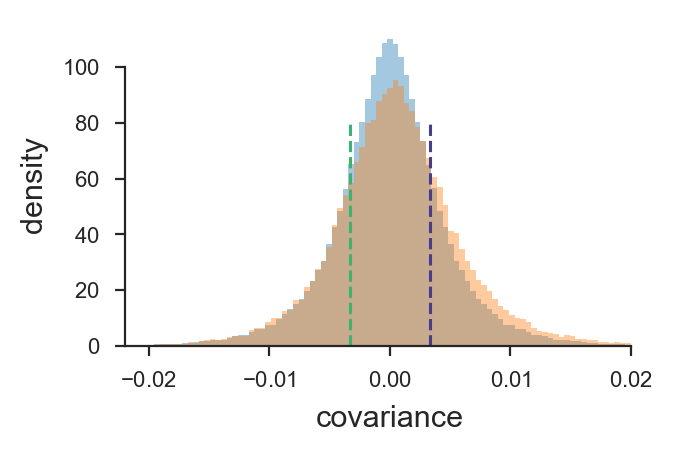

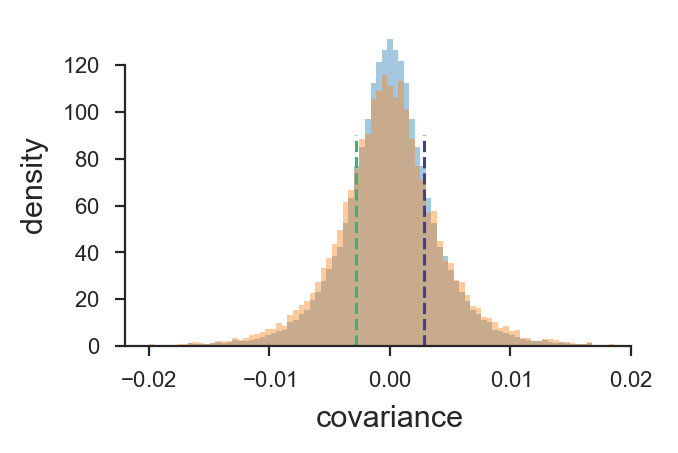

In [304]:
plt.rc('text', usetex=False)

def cov_hist(empnull, real, rep=None, k=2, bins=np.linspace(-0.03, 0.03, 15), alpha=0.4,
             ax=None, fontsize=10,
             empnull_label='sign-permuted\nneutral null', real_label='observed covariance',
             xlabel='covariance', ylabel='density'):
    assert(empnull.ndim == 5)
    rep = slice(None) if rep is None else rep
    # empnull is npermutations x nblocks x T x T x R
    # real is nblocks x T x T x R
    # after extracting diagonal, empnull_covs is npermutations x nblocks x R x U where U is elements
    # among diagonal k
    empnull_covs = np.diagonal(empnull, offset=k, axis1=2, axis2=3)[:, :, rep, :].ravel()
    real_covs = np.diagonal(real, offset=k, axis1=1, axis2=2)[:, rep, :].ravel()
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(empnull_covs, bins, alpha=alpha, density=True, label=empnull_label)
    ax.hist(real_covs, bins, alpha=alpha, density=True, label=real_label)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    return ax

alpha = 0.2
upper_tail_color='darkslateblue'
lower_tail_color='mediumseagreen'

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/1.6))
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=2, rep=None, 
         ax=ax, bins=np.linspace(-0.02, 0.02, BEST_NBINS),
         fontsize=11)

upper_tail, lower_tail = np.nanquantile(np.diagonal(barghi_emp_null_tile, 2, 2, 3), (alpha, 1-alpha))
tail_segments = [[(lower_tail, 0), (lower_tail, 80)],
                 [(upper_tail, 0), (upper_tail, 80)]]
#ax.axvline(upper_tail, c=upper_tail_color)
#ax.axvline(lower_tail, c=lower_tail_color)
lc = mc.LineCollection(tail_segments, colors=(upper_tail_color, lower_tail_color), linestyle='--')
ax.add_collection(lc)
ax.spines['left'].set_bounds(0, 100)
ax.spines['bottom'].set_bounds(-0.022, 0.020)
fig.savefig("figure-3-hists-a.pdf", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/1.6))
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=4, rep=None, 
         ax=ax, bins=np.linspace(-0.02, 0.02, BEST_NBINS),
         fontsize=11)
upper_tail, lower_tail = np.nanquantile(np.diagonal(barghi_emp_null_tile, 4, 2, 3), (alpha, 1-alpha))
#ax.legend(loc=(0.8,0.5))
tail_segments = [[(lower_tail, 0), (lower_tail, 90)],
                 [(upper_tail, 0), (upper_tail, 90)]]
#ax.axvline(upper_tail, c=upper_tail_color)
#ax.axvline(lower_tail, c=lower_tail_color)
lc = mc.LineCollection(tail_segments, colors=(upper_tail_color, lower_tail_color), linestyle='--')
ax.add_collection(lc)
ax.spines['left'].set_bounds(0, 120)
ax.spines['bottom'].set_bounds(-0.022, 0.020)
fig.savefig("figure-3-hists-b.pdf", bbox_inches='tight')
#ax[1].text(-0.02, 240, "permuted tile blocks")

### P-value calculation

This pools all replicates.

In [305]:
def calc_tail_probs(empnull, real, alpha=0.01):
    tails = np.nanquantile(empnull, (alpha, 1-alpha))
    lt, rt = np.nanmean(real < tails[0]), np.nanmean(real > tails[1])
    return np.array([lt, rt])

def bootstrap_tail_probs(empnull, real, B=1000, alpha=0.01, progress_bar=False):
    nperms, nblocks, T, T_, R = empnull.shape
    straps = []
    B_range = tnrange(B) if progress_bar else np.arange(B)
    # pre-cache all of the elements along each diagonal.
    real_ks = {k: np.diagonal(real, offset=k, axis1=1, axis2=2) for k in np.arange(1, T)}
    empnull_ks = {k: np.swapaxes(np.diagonal(empnull, offset=k, axis1=2, axis2=3), 0, 1) for k in np.arange(1, T)}
    for b in B_range:
        bidx = np.random.randint(0, nblocks, size=nblocks)
        #import pdb; pdb.set_trace()
        straps.append([calc_tail_probs(empnull_ks[k][bidx,:  :, :], real_ks[k], alpha=alpha) for k in np.arange(1, T)])
    return straps

def plot_tail_probs(tail_prob_cis, ax=None, alpha=0.01, fontsize=11,
                    upper_tail_color='darkslateblue', lower_tail_color='mediumseagreen'):
    mean = tail_prob_cis[1]
    lower, upper = tail_prob_cis[0] - mean, mean - tail_prob_cis[2]
    k = np.arange(2, 6)
    if ax is None:
        fig, ax = plt.subplots()
    ax.errorbar(k+0.05, mean[:, 0], np.stack((lower[:, 0], upper[:, 0])),
                label='left', fmt='-o', markersize=2.8, linewidth=1.6,
                linestyle='--', c=lower_tail_color)
    ax.errorbar(k-0.05, mean[:, 1], np.stack((lower[:, 1], upper[:, 1])),
                label='right', fmt='-o', markersize=2.8, linewidth=1.6,
                linestyle='--', c=upper_tail_color)
    ax.set_xticks(k)
    ax.axhline(y=alpha, c='k', alpha=0.2, linestyle='--', zorder=-1)
    ax.set_xlabel('k', fontsize=fontsize)
    ax.set_ylabel(f'{int(100*alpha)}% tail prob', fontsize=fontsize)
    return ax


### Barghi Tail Probabilities Bootstraps — Window-level Permutations

In [306]:
alphas = [0.01, 0.05, 0.1, 0.2, 0.5]

empnull_tail_probs_bootstraps = dict()
for alpha in alphas:
    FILENAME = f'../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_{alpha}.npy'
    if not os.path.exists(FILENAME):
        print(f"bootstrapping for {FILENAME}")
        empnull_tail_probs_bootstraps[alpha] = np.array(bootstrap_tail_probs(barghi_emp_null_tile, barghi_tile_covs,
                                                                             B=1000, alpha=alpha, progress_bar=True))
        with open(FILENAME, 'wb') as f:
            np.save(f, empnull_tail_probs_bootstraps[alpha])
    else:
         with open(FILENAME, 'rb') as f:
            print(f"loading bootstraps for {FILENAME}")
            empnull_tail_probs_bootstraps[alpha] = np.load(f)

loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.01.npy
loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.05.npy
loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.1.npy
loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.2.npy
loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.5.npy


In [307]:
T = 6

# estimate the tail probabilities for each k
tail_probs = dict()
for alpha in alphas:
    probs = []
    for k in np.arange(1, T):
        emp_null_covs = np.diagonal(barghi_emp_null_tile, k, 2, 3)
        obs_covs = np.diagonal(barghi_tile_covs, k, 1, 2)
        probs.append(calc_tail_probs(emp_null_covs, obs_covs, alpha=alpha))
    tail_probs[alpha] = np.array(probs)

### Barghi Empirical Tail Probabilities for α=0.01

The tail probabilities start at k=1, the bias-corrected off diagonal — the permutation procedure does not account for this, so we don't plot it.

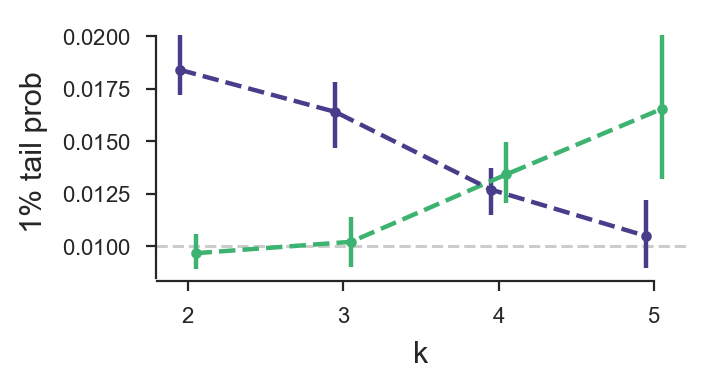

In [308]:
tail_probs_cis_01 = bootstrap_ci(tail_probs[0.01], empnull_tail_probs_bootstraps[0.01])

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_01[:, 1:, :], ax=ax, alpha=0.01)
ax.spines['left'].set_bounds(0.0085, 0.02)
ax.spines['bottom'].set_bounds(1.8, 5)
fig.savefig("tailprobs-0.01.pdf", bbox_inches='tight')

### Barghi Empirical Tail Probabilities for α=0.05

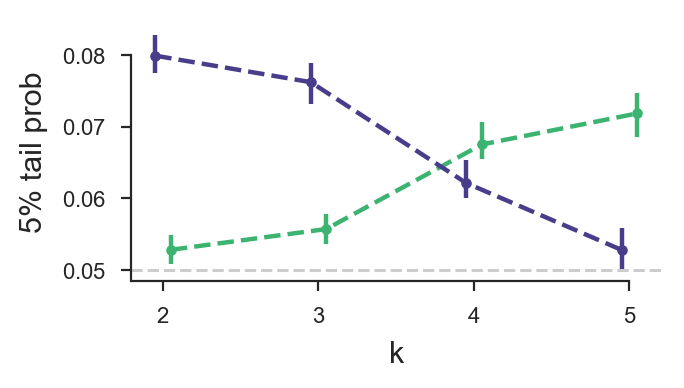

In [310]:
tail_probs_cis_05 = bootstrap_ci(tail_probs[0.05], empnull_tail_probs_bootstraps[0.05])

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_05[:, 1:, :], ax=ax, alpha=0.05)
ax.spines['left'].set_bounds(0.0485, 0.08)
ax.spines['bottom'].set_bounds(1.8, 5)
fig.savefig("tailprobs-0.05.pdf", bbox_inches='tight')

### Barghi Empirical Tail Probabilities for α=0.1

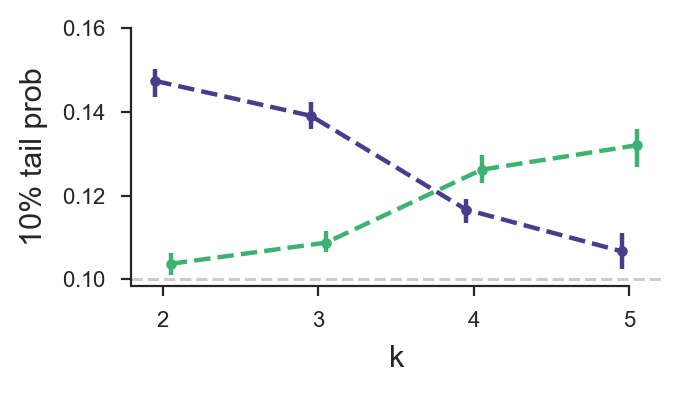

In [311]:
tail_probs_cis_10 = bootstrap_ci(tail_probs[0.10], empnull_tail_probs_bootstraps[0.10])

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_10[:, 1:, :], ax=ax, alpha=0.1)
ax.set_ylim(0.09838, 0.16)
ax.spines['left'].set_bounds(0.09838, 0.16)
ax.spines['bottom'].set_bounds(1.8, 5)
fig.savefig("tailprobs-0.10.pdf", bbox_inches='tight')

### Barghi Empirical Tail Probabilities for α=0.2

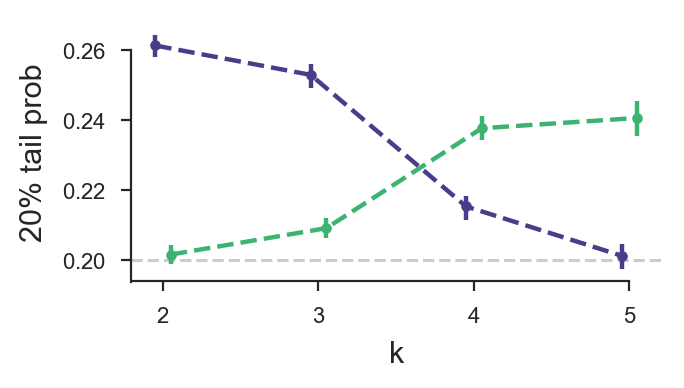

In [312]:
tail_probs_cis_20 = bootstrap_ci(tail_probs[0.20], empnull_tail_probs_bootstraps[0.20])

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_20[:, 1:, :], ax=ax, alpha=0.2)
ax.spines['left'].set_bounds(0.194, 0.26)
ax.spines['bottom'].set_bounds(1.8, 5)
fig.savefig("tailprobs-0.20.pdf", bbox_inches='tight')

In the manuscript, we cite the fold enrichment for α = 0.2; this generates those number:

In [313]:
tail_probs_cis_20[:, 1:, :] / 0.2

array([[[0.99434901, 1.29135963],
        [1.03149488, 1.24924653],
        [1.17088608, 1.06192925],
        [1.17947559, 0.98960217]],

       [[1.00847649, 1.30684901],
        [1.04611212, 1.26491863],
        [1.18874322, 1.07707957],
        [1.2034358 , 1.00678119]],

       [[1.02226492, 1.32392066],
        [1.06012658, 1.28300558],
        [1.20570185, 1.09606691],
        [1.22875226, 1.02625452]]])

### Barghi Empirical Tail Probabilities for α=0.5

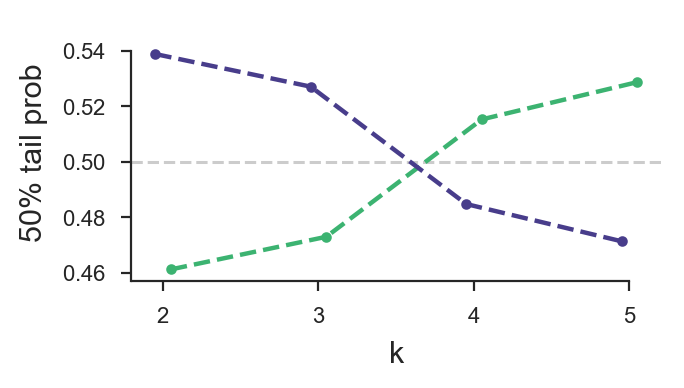

In [314]:
tail_probs_cis_50 = bootstrap_ci(tail_probs[0.5], empnull_tail_probs_bootstraps[0.5])

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_50[:, 1:, :], ax=ax, alpha=0.5)
ax.set_ylim(0.457, 0.55)
ax.spines['left'].set_bounds(0.457, 0.54)
ax.spines['bottom'].set_bounds(1.8, 5)
fig.savefig("tailprobs-0.50.pdf", bbox_inches='tight')

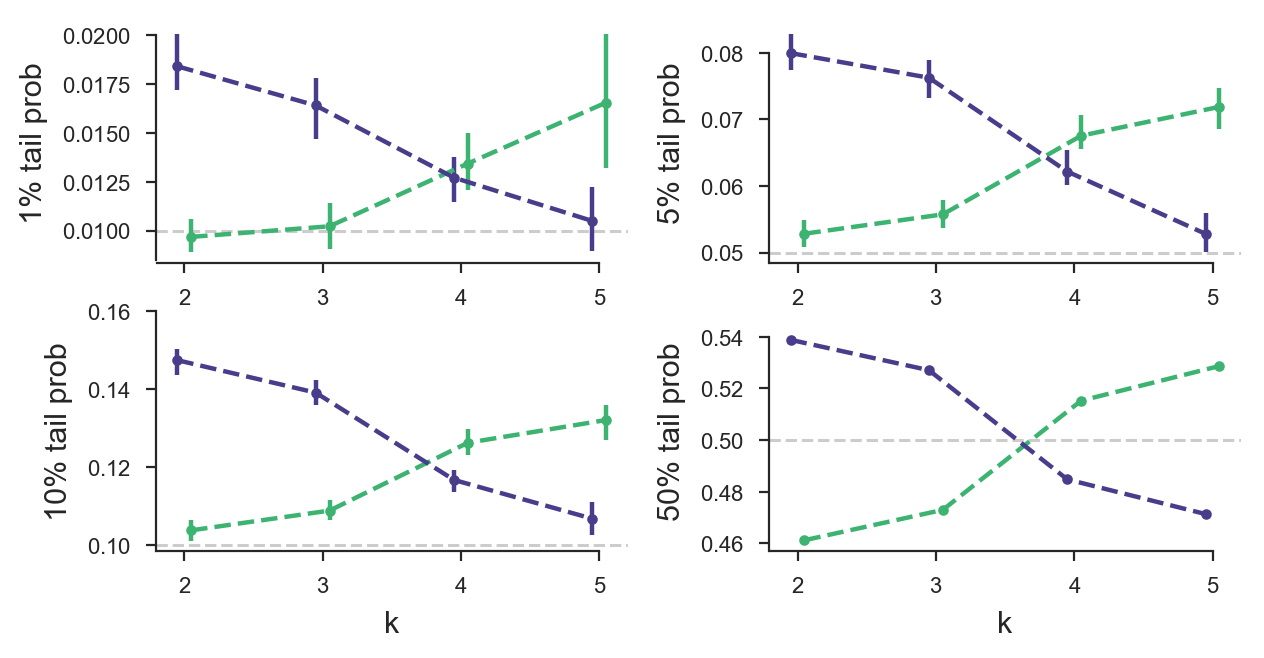

In [315]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(TWOCOL, TWOCOL/2))

plot_tail_probs(tail_probs_cis_01[:, 1:, :], ax=ax[0, 0], alpha=0.01)
ax[0, 0].spines['left'].set_bounds(0.0085, 0.02)
ax[0, 0].spines['bottom'].set_bounds(1.8, 5)
#ax[0, 0].text(3.5, 0.02, f"tail prob = 0.01", horizontalalignment='center')

plot_tail_probs(tail_probs_cis_05[:, 1:, :], ax=ax[0, 1], alpha=0.05)
ax[0, 1].spines['left'].set_bounds(0.0485, 0.08)
ax[0, 1].spines['bottom'].set_bounds(1.8, 5)
#ax[0, 1].text(3.5, 0.08, f"tail prob = 0.05", horizontalalignment='center')

plot_tail_probs(tail_probs_cis_10[:, 1:, :], ax=ax[1, 0], alpha=0.1)
ax[1, 0].set_ylim(0.09838, 0.16)
ax[1, 0].spines['left'].set_bounds(0.09838, 0.16)
ax[1, 0].spines['bottom'].set_bounds(1.8, 5)
#ax[1, 0].text(3.5, 0.16, f"tail prob = 0.10", horizontalalignment='center')

plot_tail_probs(tail_probs_cis_50[:, 1:, :], ax=ax[1, 1], alpha=0.5)
ax[1, 1].set_ylim(0.457, 0.55)
ax[1, 1].spines['left'].set_bounds(0.457, 0.54)
ax[1, 1].spines['bottom'].set_bounds(1.8, 5)
#ax[1, 1].text(3.5, 0.54, f"tail prob = 0.50", horizontalalignment='center')

plt.subplots_adjust(wspace=.3)
fig.savefig("barghi-tailprobs-panels.pdf", bbox_inches='tight')


### More Barhi offset distribution plots

/Users/vinceb/miniconda3/envs/basesci/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/vinceb/miniconda3/envs/basesci/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """
/Users/vinceb/miniconda3/envs/basesci/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys
/Users/vinceb/miniconda3/envs/basesci/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


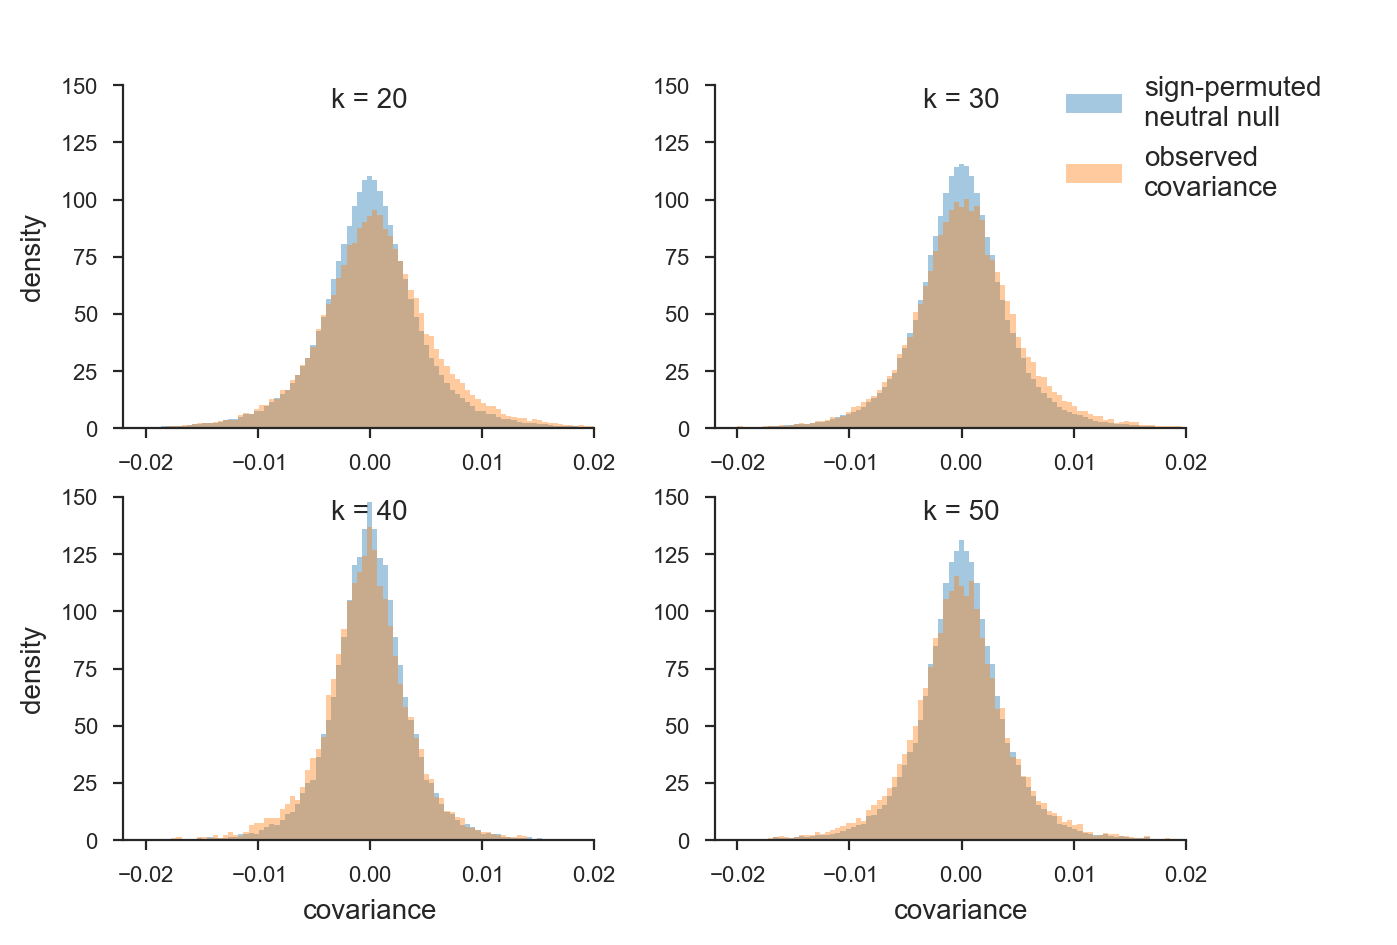

In [316]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(TWOCOL, TWOCOL/1.4))
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=2, rep=None, ax=ax[0, 0], 
         bins=np.linspace(-0.02, 0.02, BEST_NBINS), xlabel='', real_label='observed\ncovariance')
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=3, rep=None, ax=ax[0, 1],
         bins=np.linspace(-0.02, 0.02, BEST_NBINS), xlabel='', ylabel='', real_label='observed\ncovariance')
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=4, rep=None, ax=ax[1, 1], 
         bins=np.linspace(-0.02, 0.02, BEST_NBINS), ylabel='', real_label='observed\ncovariance')
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=5, rep=None, ax=ax[1, 0], 
         bins=np.linspace(-0.02, 0.02, BEST_NBINS), real_label='observed\ncovariance')
for k, (i, j) in enumerate([(i, j) for i in (0, 1) for j in (0, 1)], 2):
    ax[i, j].set_ylim([0, 150])
    ax[i, j].text(0, 140, f"k = {10*k}", horizontalalignment='center')
    ax[i, j].spines['bottom'].set_bounds(-0.022, 0.02)
    if i == 0 and j == 1:
        ax[i, j].legend(loc=(0.6, 0.5))

plt.savefig('barghi-offset-panels.pdf', bbox_inches="tight")

### Barghi Windowed Covariance Plot for Particular Replicates

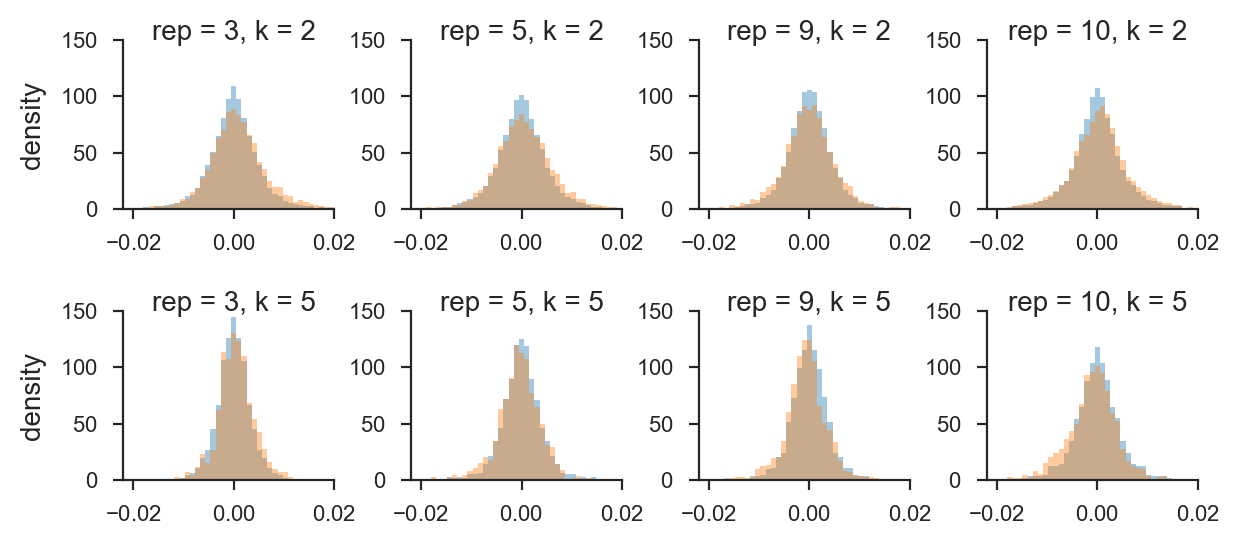

In [318]:
np.random.seed(0)
nreps = 4
fig, ax = plt.subplots(ncols=nreps, nrows=2, figsize=(TWOCOL, TWOCOL/2.4))

reps = sorted(np.random.choice(np.arange(10), replace=False, size=nreps))
ks = [2, 5]

for i in range(nreps):
    for j in (0, 1):
        ylabel = '' if i > 0 else 'density'
        cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=ks[j], ax=ax[j, i], rep=reps[i], 
             bins=np.linspace(-0.02, 0.02, 40), xlabel='', ylabel=ylabel, real_label='observed\ncovariance')
        ymax = 150 
        ax[j, i].set_ylim(0, ymax)
        ax[j, i].spines['left'].set_bounds(0, ymax)
        ax[j, i].spines['bottom'].set_bounds(-0.022, 0.02)
        ax[j, i].text(0, ymax, f'rep = {reps[i]+1}, k = {ks[j]}', horizontalalignment='center')

plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.savefig('barghi-offset-replicate-panels.pdf', bbox_inches="tight")

## Chromosome-level sign permutation

In [476]:
alphas = [0.01, 0.05, 0.1, 0.2, 0.5]

empnull_tail_probs_bootstraps_seqid = dict()
for alpha in alphas:
    FILENAME = f'../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_{alpha}_seqid.npy'
    if not os.path.exists(FILENAME):
        print(f"bootstrapping for {FILENAME}")
        empnull_tail_probs_bootstraps_seqid[alpha] = np.array(bootstrap_tail_probs(barghi_emp_null_seqid, barghi_tile_covs,
                                                                                   B=1000, alpha=alpha, progress_bar=True))
        with open(FILENAME, 'wb') as f:
            np.save(f, empnull_tail_probs_bootstraps_seqid[alpha])
    else:
         with open(FILENAME, 'rb') as f:
            print(f"loading bootstraps for {FILENAME}")
            empnull_tail_probs_bootstraps_seqid[alpha] = np.load(f)

loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.01_seqid.npy
loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.05_seqid.npy
loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.1_seqid.npy
loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.2_seqid.npy
loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.5_seqid.npy


In [477]:
T = 6

# estimate the tail probabilities for each k
tail_probs_seqid = dict()
for alpha in alphas:
    probs = []
    for k in np.arange(1, T):
        emp_null_covs = np.diagonal(barghi_emp_null_seqid, k, 2, 3)
        obs_covs = np.diagonal(barghi_tile_covs, k, 1, 2)
        probs.append(calc_tail_probs(emp_null_covs, obs_covs, alpha=alpha))
    tail_probs_seqid[alpha] = np.array(probs)

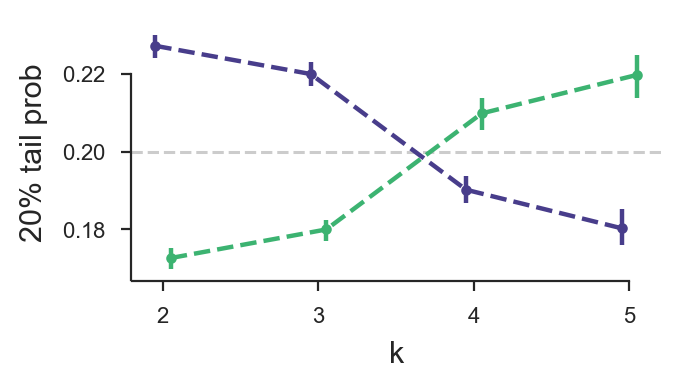

In [480]:
tail_probs_cis_20_seqid = bootstrap_ci(tail_probs_seqid[0.2], empnull_tail_probs_bootstraps_seqid[0.2])

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_20_seqid[:, 1:, :], ax=ax, alpha=0.2)
ax.spines['left'].set_bounds(0.167, 0.22)
ax.spines['bottom'].set_bounds(1.8, 5)
fig.savefig("barghi-tailprobs-seqid-20.pdf")

## Bergland et al (2014) Re-Analysis Plots

In [351]:
pvalue_comparison = pd.read_csv('../../data/bergland_et_al_2014/bergland_pvalue_comparison.csv')

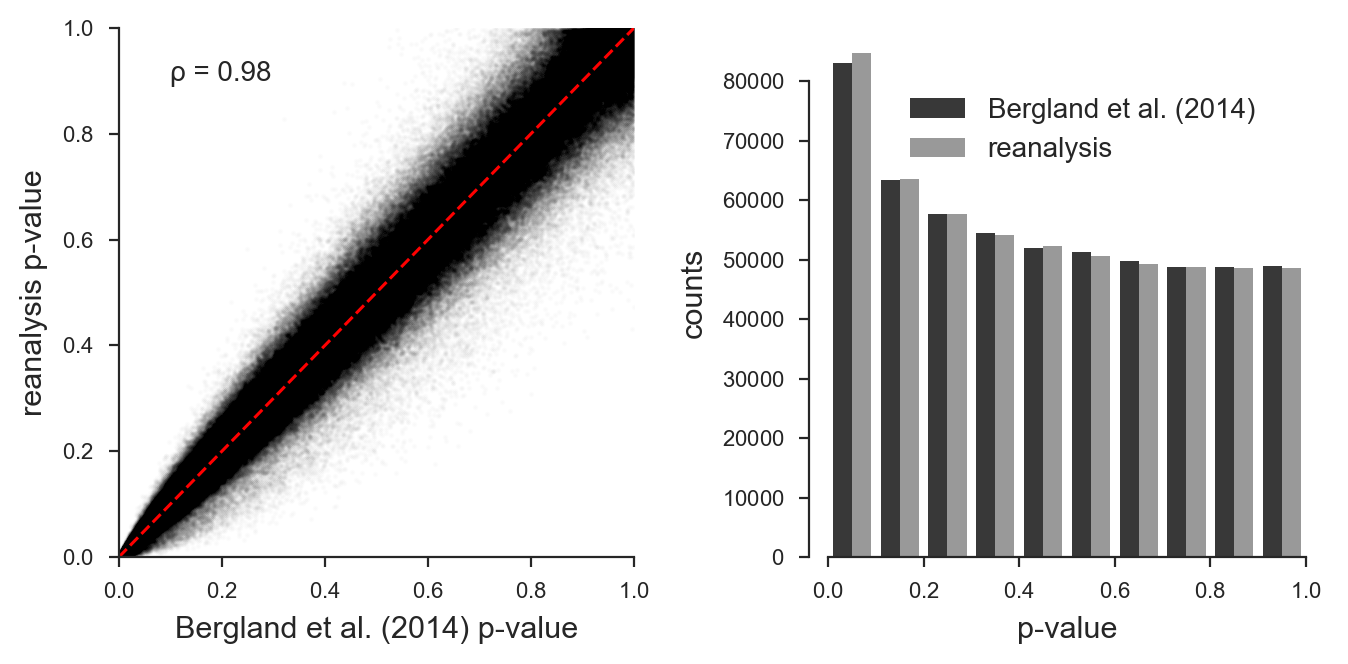

In [481]:
def abline(ax, slope=1, intercept=0, **kwargs):
    x = np.array(ax.get_xlim())
    y = intercept + slope * x
    ax.plot(x, y, '--', **kwargs)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(2*ONECOL, ONECOL))
bergland_pvals, our_pvals = pvalue_comparison['bergland_pvals'].values, pvalue_comparison['our_pvals'].values
ax[0].scatter(bergland_pvals, our_pvals, alpha=0.01, s=1, c='k')
#ax.hist2d(-np.log10(SP+1), -np.log10(pvals+1), 30)
ax[0].text(0.1, 0.9, f"ρ = {np.corrcoef(bergland_pvals, our_pvals)[0, 1].round(2)}")
r = np.corrcoef(bergland_pvals, our_pvals)
n = our_pvals.size
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
ax[0].spines['left'].set_bounds(ax[0].get_ylim()[0], 1)
ax[0].spines['bottom'].set_bounds(ax[0].get_xlim()[0], 1)
ax[0].set_ylabel("reanalysis p-value")
ax[0].set_xlabel("Bergland et al. (2014) p-value")
abline(ax[0], c='r')

ax[1].hist(np.stack((bergland_pvals, our_pvals)).T, 10,
           label=("Bergland et al. (2014)", "reanalysis"), 
           color=(str(56/255), str(153/255)))
ax[1].spines['left'].set_bounds(ax[0].get_ylim()[0], 80000)
ax[1].spines['bottom'].set_bounds(ax[0].get_xlim()[0], 1)
ax[1].set_ylabel("counts")
ax[1].set_xlabel("p-value")
ax[1].legend()
plt.tight_layout()
plt.savefig('bergland-pvalue-comparison.png', bbox_inches="tight")

In [395]:
with open('../../data/bergland_et_al_2014/locus_level_permutation_pvalues.npy', 'rb') as f:
    locus_permuted_pvals = np.load(f)

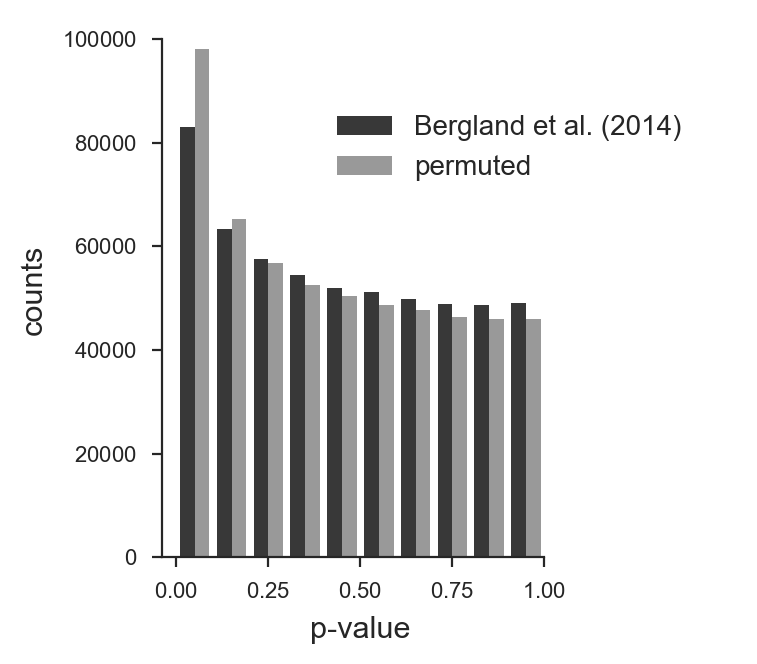

In [475]:
NREPS = locus_permuted_pvals.shape[0]
labels = tuple(['seasonal'] + [f'permuted-{r+1}' for r in range(NREPS)])
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(ONECOL, ONECOL))
h = ax.hist(np.hstack((bergland_pvals.reshape(-1, 1), locus_permuted_pvals[0, :, np.newaxis])), 10, 
        label=('Bergland et al. (2014)', 'permuted'),
        color=[str(56/255), str(153/255)])
ax.legend(loc=(0.3, 0.6))
ax.spines['left'].set_bounds(ax.get_ylim()[0], 100000)
ax.spines['bottom'].set_bounds(ax.get_xlim()[0], 1)
ax.set_ylabel('counts')
ax.set_xlabel('p-value')

# rep_ys = [np.histogram(locus_permuted_pvals[i, :], 10)[0] for i in range(NREPS)]
# min = np.array(rep_ys).min(axis=0)
# max = np.array(rep_ys).max(axis=0)
# ax.vlines(np.linspace(0, 1, 10), ymin=min, ymax=max)
plt.tight_layout()
plt.savefig('bergland-pvalue-permutation-hist.pdf', bbox_inches="tight")


## Barghi et al (2019) Correction Plots

In [339]:
with open('../../data/barghi_et_al_2019/diagonistics_tuple.pkl', 'rb') as f:
    barghi_diagonistics = pickle.load(f)

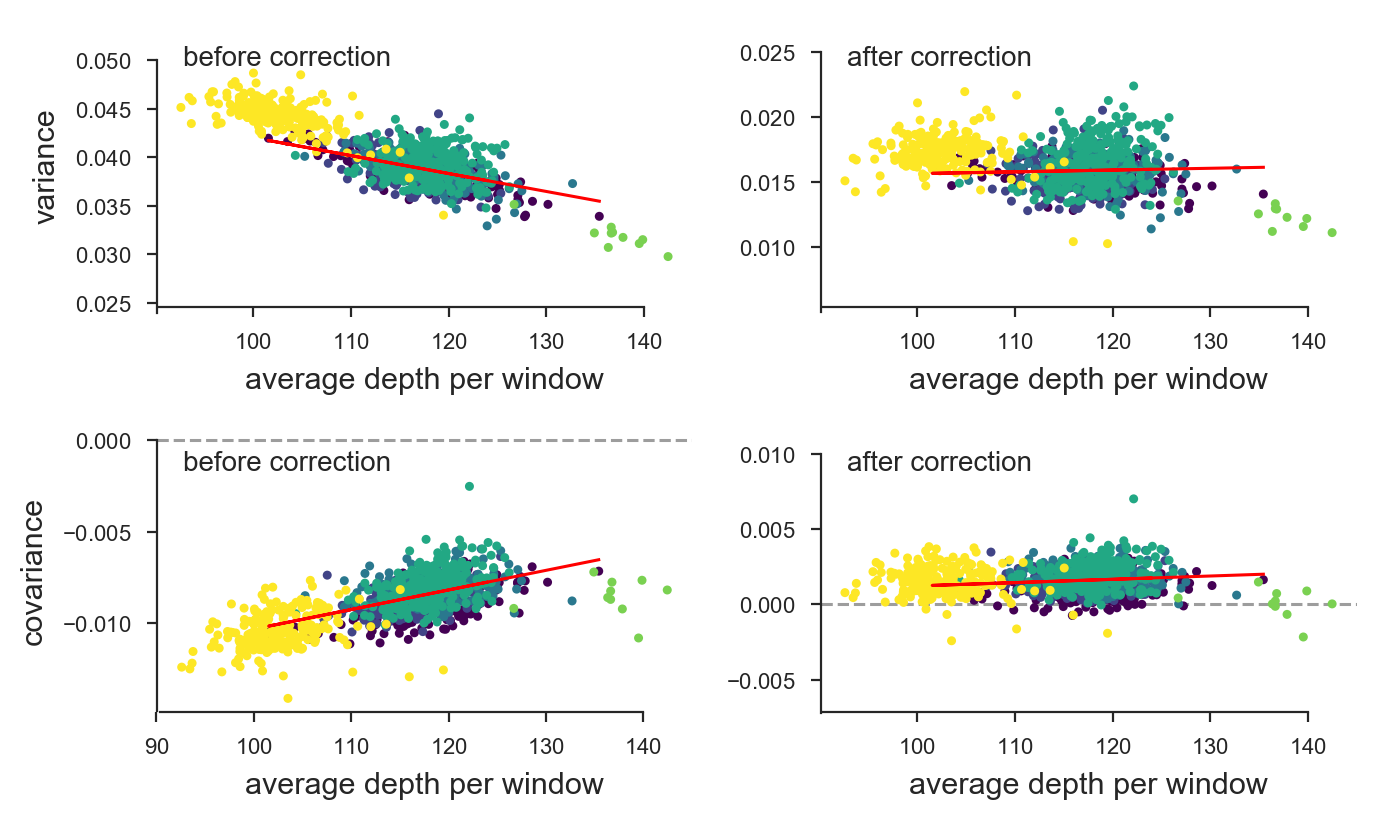

In [340]:
plt.rc('text', usetex=False)
fig, ax = correction_diagnostic_plot(barghi_diagonistics, figsize=(TWOCOL, TWOCOL*0.6))

ax[0, 0].spines['left'].set_bounds(0.024, 0.05)
ax[0, 0].spines['bottom'].set_bounds(90.4, 140)

ax[0, 1].spines['left'].set_bounds(0.005, 0.025)
ax[0, 1].spines['bottom'].set_bounds(90.4, 140)

ax[1, 0].spines['left'].set_bounds(-0.0148, 0.0)
ax[1, 0].spines['bottom'].set_bounds(90.4, 140)


ax[1, 1].spines['left'].set_bounds(-0.0072, 0.01)
ax[1, 1].spines['bottom'].set_bounds(90.4, 140)

plt.savefig('barghi-correction-plot.pdf', bbox_inches="tight")

# Old Stuff

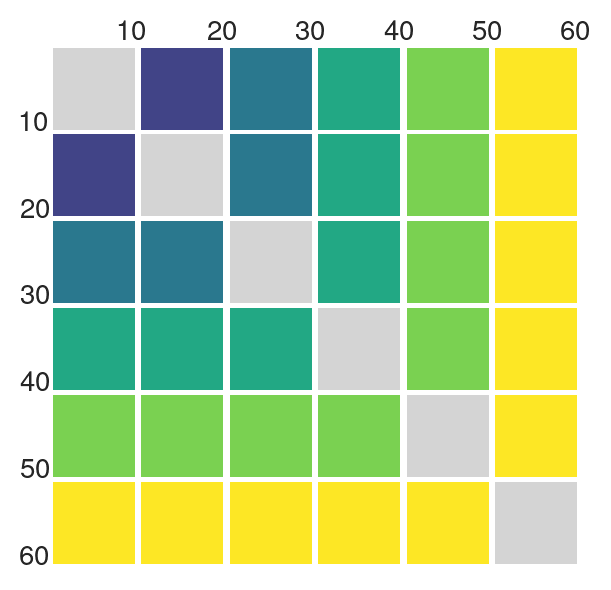

In [111]:
def make_grid(T):
    M = np.zeros((T, T))
    rows, cols = np.indices((T, T))
    for t in np.arange(T)[::-1]:
        M[(cols <= t) & (rows <= t)] = t
    np.fill_diagonal(M, np.nan)
    return M

#plt.imshow(make_grid(T))

# import matplotlib.gridspec as gridspec
# gs = gridspec.GridSpec(T, T)
# gs.update(wspace=0.01, hspace=0.04)

T = 6

fig, ax = plt.subplots(nrows=T, ncols=T, figsize=(ONECOL, ONECOL))
M = np.zeros((T, T))
rows, cols = np.indices((T, T))
bg_cols = cm.viridis(np.linspace(0, 1, T))

for t in np.arange(T)[::-1]:
    for r in np.arange(t):
        ax[r,t].set_facecolor(bg_cols[t])
        ax[t,r].set_facecolor(bg_cols[t])
    for r in np.arange(T):
        if r == t:
            ax[t,r].set_facecolor('44')
        ax[t, r].set_aspect('equal')
        ax[r, t].set_aspect('equal')
        
        ax[t, r].get_xaxis().set_visible(False)
        ax[r, t].get_xaxis().set_visible(False)
        ax[t, r].get_yaxis().set_visible(False)
        ax[t, r].get_yaxis().set_visible(False)
        
        ax[t, r].spines['top'].set_visible(False)
        ax[t, r].spines['right'].set_visible(False)
        ax[t, r].spines['left'].set_visible(False)
        ax[t, r].spines['bottom'].set_visible(False)
        if r == 0:
            ax[r, t].text(0.8, 1.1, (t+1)*10)
        if t == 0:
            ax[r, t].text(-0.4, 0, (r+1)*10)
plt.subplots_adjust(wspace=0.01, hspace=0.06)